# Compare Hallmark NACT NES through paired analysis

Script related to figure 6a

### Aim:
- Compare gene sets NES (matched and unmatched) using paired analysis

In [1]:
!python --version

Python 3.6.8 :: Anaconda custom (64-bit)


## Import packages

In [2]:
import sys
import scipy
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.stats.mstats import normaltest
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import shapiro, kstest, ttest_rel, wilcoxon, mannwhitneyu, ttest_ind, bartlett, levene

In [3]:
home = '~/git_repos/HGSOC_TME_Heterogeneity/'

## Get sample labels

### Load file

In [4]:
file_keys = home + 'Data/5/NACT_SampleLabels.txt'

sample_labels = pd.read_csv(file_keys,
                            sep='\t',
                            index_col='Well')

sample_labels.head()

,Name,Case_mRNA,NACT,Site,Bounds
Well,,,,,
A01,A01_3368A_Liver,3368,Untreated,other,in
A02,A02_3368B_Liver,3368,Treated,other,out
A03,A03_0371A_R_diaphragm,371,Untreated,other,out
A04,A04_0371B_R_diaphragm,371,Treated,other,out
A05,A05_9717A_R_ovary,9717,Untreated,ovary,in


In [5]:
len(set(sample_labels.Case_mRNA))

28

In [6]:
matched = [3368,371,9717,8674,2359,564,7765,6965,9347]

sample_labels['Matched']=sample_labels['Case_mRNA'].isin(matched)

sample_labels.head()

,Name,Case_mRNA,NACT,Site,Bounds,Matched
Well,,,,,,
A01,A01_3368A_Liver,3368,Untreated,other,in,True
A02,A02_3368B_Liver,3368,Treated,other,out,True
A03,A03_0371A_R_diaphragm,371,Untreated,other,out,True
A04,A04_0371B_R_diaphragm,371,Treated,other,out,True
A05,A05_9717A_R_ovary,9717,Untreated,ovary,in,True


## Load hallmark ssGSEA results

In [7]:
file_nes = home + 'Data/5/HallmarksStromaImmune_NACT_NES.txt'

data_nes = pd.read_csv(file_nes, sep='\t')

data_nes.set_index('Term', inplace=True)

data_nes.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.092696,0.159109,0.221560,0.210024,0.099785,0.118758,0.100212,0.272152,0.108368,0.099014,...,0.166682,0.180770,0.182044,0.123420,0.167660,0.177934,0.175181,0.249246,0.163605,0.283639
HALLMARK_HYPOXIA,0.186010,0.196143,0.214819,0.237168,0.192770,0.204423,0.165283,0.278923,0.201645,0.195268,...,0.213112,0.231052,0.221524,0.238599,0.243462,0.232689,0.204692,0.258383,0.231907,0.286908
HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.255208,0.282680,0.285083,0.260298,0.321267,0.309121,0.292943,0.313486,0.286084,0.277111,...,0.322881,0.262719,0.292338,0.381793,0.237000,0.292132,0.267533,0.301603,0.295406,0.393218
HALLMARK_MITOTIC_SPINDLE,0.305218,0.317705,0.293826,0.255306,0.278673,0.302507,0.298289,0.265211,0.338190,0.302091,...,0.292191,0.312170,0.317407,0.400398,0.324670,0.305270,0.306001,0.298000,0.302720,0.303047
HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.218775,0.238017,0.212214,0.256485,0.252541,0.250670,0.242941,0.173667,0.262190,0.294071,...,0.245270,0.289621,0.233977,0.296323,0.177104,0.233127,0.223970,0.227052,0.261404,0.235832


### Check empty cells

In [8]:
set(data_nes.isnull().sum())

{0}

## Load mRNA tumour cellularity data

In [9]:
mRNA_tumcell_file = home + 'Data/5/NACT_log2exp_loess_norm_filtered_ESTIMATE.txt'

mRNA_tumcell = pd.read_csv(mRNA_tumcell_file,
                           skiprows=2,
                           sep='\t',
                           index_col='NAME')

del(mRNA_tumcell['Description'])

mRNA_tumcell.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
NAME,,,,,,,,,,,,,,,,,,,,,
StromalScore,150.243978,100.962227,967.051900,808.453034,-65.569315,489.893858,490.720381,1061.377025,235.450362,418.150347,...,263.744096,464.939728,802.734452,153.081049,1103.804616,579.702569,788.616732,1237.456125,887.344608,501.153545
ImmuneScore,176.145317,526.978700,1297.193578,1203.727348,131.468582,650.323221,407.055460,1082.029608,88.028614,282.209677,...,481.526245,516.592649,582.005013,29.396052,908.321033,258.334588,849.462145,1496.053219,969.848566,621.394231
ESTIMATEScore,326.389295,627.940928,2264.245478,2012.180381,65.899267,1140.217080,897.775841,2143.406633,323.478976,700.360025,...,745.270341,981.532377,1384.739465,182.477100,2012.125649,838.037157,1638.078877,2733.509343,1857.193174,1122.547776
TumorPurity,0.794327,0.766668,0.591924,0.621334,0.816969,0.716267,0.740642,0.606127,0.794586,0.759799,...,0.755497,0.732326,0.690764,0.806982,0.621341,0.746506,0.663403,0.535046,0.638998,0.718075


### Add mRNA tumour cellularity to NES dataframe

In [10]:
data_nes_t = data_nes.T

In [11]:
data_nes_t['TumourCellularity_mRNA'] = mRNA_tumcell.loc['TumorPurity']

In [12]:
data_nes = data_nes_t.T

In [13]:
data_nes.tail()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_KRAS_SIGNALING_DN,-0.111366,-0.116319,-0.122007,-0.096597,-0.106269,-0.118997,-0.102549,-0.109274,-0.136147,-0.115405,...,-0.139325,-0.162815,-0.121599,-0.190920,-0.141080,-0.111751,-0.141831,-0.126286,-0.127925,-0.167178
HALLMARK_PANCREAS_BETA_CELLS,-0.146457,-0.171530,-0.229520,-0.139607,-0.137008,-0.151976,-0.239809,-0.162335,-0.164499,-0.187457,...,-0.228200,-0.152731,-0.218332,-0.196034,-0.157134,-0.126800,-0.179381,-0.216867,-0.193094,-0.209325
StromalSignature,0.068301,0.070667,0.269651,0.224186,0.023423,0.157401,0.155407,0.292664,0.095977,0.135368,...,0.104112,0.155909,0.228005,0.088713,0.296492,0.180196,0.221126,0.332099,0.245865,0.172484
ImmuneSignature,0.074691,0.169467,0.345730,0.317359,0.069114,0.197182,0.135779,0.299572,0.063372,0.103880,...,0.153753,0.167914,0.175292,0.058984,0.256096,0.108475,0.235833,0.393539,0.265829,0.201392
TumourCellularity_mRNA,0.794327,0.766668,0.591924,0.621334,0.816969,0.716267,0.740642,0.606127,0.794586,0.759799,...,0.755497,0.732326,0.690764,0.806982,0.621341,0.746506,0.663403,0.535046,0.638998,0.718075


### Visulase NES

#### Samples

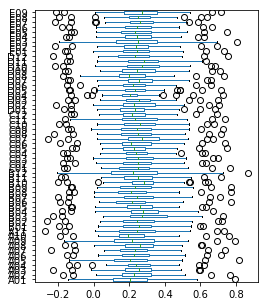

In [14]:
data_nes.plot(kind='box',
              vert=False,
              figsize=(4,5))

#### Variables

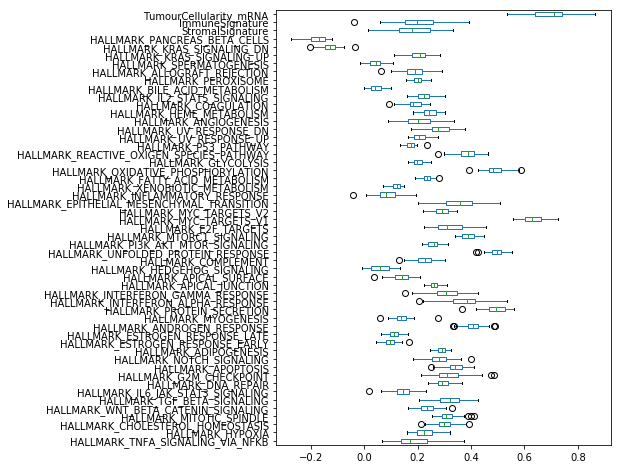

In [15]:
data_nes.transpose().plot(kind='box',
                          vert=False,
                          figsize=(6,8))

### Define stat functions for volcano plot

#### Test for equal variances

In [16]:
def test_variances(df, score, norm, not_norm):
    """
    test equal variances
    """
    
    if norm > not_norm:
    
        p_var = bartlett(df[df.NACT=='Treated'][score],
                         df[df.NACT=='Untreated'][score])[1]
        
    else:
        
        print("Hi")
        
        raise("ValueError")
        
        p_var = levene(df[df.NACT=='Treated'][score],
                         df[df.NACT=='Untreated'][score])[1]

    return p_var

#### Test normality

In [17]:
def test_normality_and_variance(df, score):
    """
    test normality of distributions
    """
    normality = []
    normality.append(shapiro(df[df.NACT=='Treated'][score])[1])
    normality.append(shapiro(df[df.NACT=='Untreated'][score])[1])
    
    mean = np.mean(df[df.NACT=='Treated'][score])
    std = np.std(df[df.NACT=='Treated'][score])
    normality.append(kstest(list(df[df.NACT=='Treated'][score]),
                            'norm', args=(mean,std))[1])
    
    mean = np.mean(df[df.NACT=='Untreated'][score])
    std = np.std(df[df.NACT=='Untreated'][score])
    normality.append(kstest(list(df[df.NACT=='Untreated'][score]),
                            'norm', args=(mean,std))[1])
    
    normality.append(normaltest(list(df[df.NACT=='Treated'][score]))[1])
    normality.append(normaltest(list(df[df.NACT=='Untreated'][score]))[1])
    
    norm = 0
    not_norm = 0
    for p in normality:
        if p > 0.05:
            norm += 1
        else:
            not_norm += 1
            
    if norm > not_norm:
        p_var = test_variances(df, score, norm, not_norm)
        if p_var > 0.05:            
            return 't-test'
        else:
            return 'welch'
    else:        
        return 'wilcoxon'

#### Test difference

In [18]:
def test_difference(df, score, norm):
    """
    test difference with paired t test or wilcoxon
    """
    if norm == 't-test':
        p_val = (ttest_rel(df[df.NACT=='Treated'][score],
                 df[df.NACT=='Untreated'][score])[1])
    elif norm == 'welch':
        p_val = (ttest_ind(df[df.NACT=='Treated'][score],
                 df[df.NACT=='Untreated'][score], equal_var=False)[1])
    elif norm == 'wilcoxon':
        p_val = (wilcoxon(df[df.NACT=='Treated'][score],
                 df[df.NACT=='Untreated'][score])[1])
    else:
        raise ValueError()
        
    return p_val

#### Get NES difference

In [19]:
def nes_difference(df, score):
    """
    get NES difference between groups
    """    
    
    df['norm01'] = (df[score] - df[score].min())/(df[score].max()-df[score].min())
    
    nes_treated = df[df.NACT=='Treated']['norm01'].median()
    nes_untreated = df[df.NACT=='Untreated']['norm01'].median()
 
    nes_norm_dif = np.log2(nes_treated/nes_untreated)

    return nes_norm_dif, nes_treated, nes_untreated

### Get fdr nes q values

In [20]:
def nes_q_values(df, score):
    """
    get treated and untreated median q-values from ssGSEA
    """
    
    nes_treated_qvalue = df[df.NACT=='Treated'][score].median()
    nes_untreated_qvalue = df[df.NACT=='Untreated'][score].median()
    
    return nes_treated_qvalue, nes_untreated_qvalue

### Gene set matched size (i.e. the overlapping genes btw my array and the set)

In [21]:
loess_exp = pd.read_csv(home + 'Data/5/NACT_log2exp_loess_norm.txt',
                        sep='\t',
                        index_col='Hugo_Symbol')

loess_exp.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,3.878105,3.954775,3.854334,3.974302,3.760565,3.757145,3.734362,3.935987,3.807211,3.514725,...,3.919331,3.896646,4.027690,3.685888,3.765937,4.086110,4.000239,3.662362,3.896871,3.654871
A2BP1,2.862997,3.279474,3.957806,3.993876,3.641308,3.249292,3.347323,3.358668,3.616479,3.572950,...,3.490291,4.059473,3.679676,3.418869,2.924245,3.346328,3.899451,3.933936,4.425151,3.723115
A2M,5.516461,5.882656,6.421447,5.980470,5.049547,5.220719,5.492205,6.471173,5.341425,5.482726,...,6.366298,6.483692,5.784733,4.950854,6.164623,4.974455,6.709993,6.645714,6.391323,6.134008
A2ML1,3.958668,4.100177,3.250522,3.396357,3.851866,4.052745,3.635604,3.143886,3.999510,3.988277,...,3.300078,3.488284,3.120832,3.868837,3.519030,3.891299,3.151470,3.353788,3.617326,3.950268
A4GALT,3.087003,2.995708,3.395173,2.859539,2.976988,3.332730,3.317251,3.490682,3.087911,3.153865,...,3.440970,3.364598,3.214461,2.922184,3.054724,2.811116,2.929423,3.364648,3.325120,3.196659


### Get gene sets

In [22]:
hallmark_genesets = pd.read_csv(
    home + 'Data/1/HallmarksStromaImmune_GeneSets.txt',
    sep = '\t',
    header = None,
    index_col = 0
)

hallmark_genesets.drop(
    1,
    axis = "columns",
    inplace=True
)

hallmark_genesets.tail()

,2,3,4,5,6,7,8,9,10,11,...,192,193,194,195,196,197,198,199,200,201
0,,,,,,,,,,,,,,,,,,,,,
HALLMARK_KRAS_SIGNALING_UP,ANGPTL4,ITGA2,SPRY2,HBEGF,RBP4,HSD11B1,ETV4,GLRX,DUSP6,SCG5,...,WDR33,MYCN,FCER1G,PECAM1,FAM190B,SNAP91,EVI5,TNFRSF1B,GPNMB,TPH1
HALLMARK_KRAS_SIGNALING_DN,CDH16,SPTBN2,FGFR3,NOS1,PDE6B,SIDT1,NTF3,SCN10A,TAS2R4,DTNB,...,ZFP112,TFAP2B,CCDC132,CD80,ATP4A,ARPP21,SERPINB2,TLX1,EFHD1,P2RY4
HALLMARK_PANCREAS_BETA_CELLS,PAX6,NEUROD1,ISL1,NKX2-2,PCSK1,NKX6-1,SLC2A2,SEC11A,DCX,SPCS1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StromalSignature,DCN,PAPPA,SFRP4,THBS2,LY86,CXCL14,FOXF1,COL10A1,ACTG2,APBB1IP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ImmuneSignature,LCP2,LSP1,FYB,PLEK,HCK,IL10RA,LILRB1,NCKAP1L,LAIR1,NCF2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def get_matched_size(genesets, exp_matrix):
    size = {}
    for geneset in genesets.index:

        if geneset not in size:
            size[geneset] = {}
        else:
            raise ValueError('1')

        size[geneset] = len(set(genesets.loc[geneset])&set(exp_matrix.index))
    
    return size

In [24]:
hallmark_msize = get_matched_size(hallmark_genesets, loess_exp)

#### Select gene sets

In [25]:
h_size_dt = hallmark_msize

In [26]:
h_size_dt['StromalScore'] = h_size_dt['StromalSignature']
h_size_dt['ImmuneScore'] = h_size_dt['ImmuneSignature']

In [27]:
h_size_dt['TumourCellularity_mRNA'] = h_size_dt['StromalSignature'] + h_size_dt['ImmuneSignature']

### Define gene set colors

In [28]:
GREEN = '#007F00'
RED = '#CC0000'
GREY = '#D3D3D3'
BLUE = '#0000E5'
YELLOW = '#FFFF00'

color_sets = {
'HALLMARK_INTERFERON_ALPHA_RESPONSE':           GREEN,
'HALLMARK_INTERFERON_GAMMA_RESPONSE':           GREEN,
'ImmuneSignature':                              GREEN,
'HALLMARK_E2F_TARGETS':                         RED,
'HALLMARK_SPERMATOGENESIS':                     GREY,
'HALLMARK_INFLAMMATORY_RESPONSE':               GREEN,
'HALLMARK_G2M_CHECKPOINT':                      RED,
'HALLMARK_PANCREAS_BETA_CELLS':                 GREY,
'HALLMARK_OXIDATIVE_PHOSPHORYLATION':           GREY,
'HALLMARK_MYC_TARGETS_V1':                      RED,
'HALLMARK_FATTY_ACID_METABOLISM':               GREY,
'HALLMARK_PEROXISOME':                          GREY,
'HALLMARK_DNA_REPAIR':                          RED,
'HALLMARK_UNFOLDED_PROTEIN_RESPONSE':           'purple',
'HALLMARK_KRAS_SIGNALING_DN':                   RED,
'HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY':     'purple',
'HALLMARK_CHOLESTEROL_HOMEOSTASIS':             GREY,
'HALLMARK_COMPLEMENT':                          GREEN,
'HALLMARK_MTORC1_SIGNALING':                    RED,
'HALLMARK_IL2_STAT5_SIGNALING':                 GREEN,
'HALLMARK_ADIPOGENESIS':                        GREY,
'HALLMARK_KRAS_SIGNALING_UP':                   RED,
'HALLMARK_HEME_METABOLISM':                     GREY,
'HALLMARK_PI3K_AKT_MTOR_SIGNALING':             RED,
'HALLMARK_ANDROGEN_RESPONSE':                   GREY,
'HALLMARK_PROTEIN_SECRETION':                   GREY,
'HALLMARK_P53_PATHWAY':                         RED,
'HALLMARK_UV_RESPONSE_UP':                      'purple',
'HALLMARK_MYC_TARGETS_V2':                      RED,
'StromalSignature':                             BLUE,
'HALLMARK_MITOTIC_SPINDLE':                     RED,
'HALLMARK_GLYCOLYSIS':                          RED,
'HALLMARK_APICAL_JUNCTION':                     BLUE,
'HALLMARK_HYPOXIA':                             'purple',
'HALLMARK_TNFA_SIGNALING_VIA_NFKB':             GREEN,
'HALLMARK_APOPTOSIS':                           GREY,
'HALLMARK_APICAL_SURFACE':                      GREY,
'HALLMARK_UV_RESPONSE_DN':                      'purple',
'HALLMARK_TGF_BETA_SIGNALING':                  'purple',
'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION':   BLUE,
'HALLMARK_NOTCH_SIGNALING':                     RED,
'HALLMARK_WNT_BETA_CATENIN_SIGNALING':          RED,
'HALLMARK_ALLOGRAFT_REJECTION':                 GREEN,
'HALLMARK_XENOBIOTIC_METABOLISM':               GREY,
'HALLMARK_ANGIOGENESIS':                        BLUE,
'HALLMARK_BILE_ACID_METABOLISM':                GREY,
'HALLMARK_COAGULATION':                         GREY,
'HALLMARK_ESTROGEN_RESPONSE_EARLY':             GREY,
'HALLMARK_ESTROGEN_RESPONSE_LATE':              GREY,
'HALLMARK_HEDGEHOG_SIGNALING':                  RED,
'HALLMARK_IL6_JAK_STAT3_SIGNALING':             GREEN,
'HALLMARK_MYOGENESIS':                          GREY,
'TumourCellularity_mRNA':                       'k'
}

### Make dict with score -> q-value_diff, es-difference, es, q-value_Enrichment

In [29]:
msize_dt = h_size_dt

In [30]:
scores = []
p_comparisons = []
nes_dif = []
nes_treated_list = []
nes_untreated_list = []
nes_norm_treated_list = []
nes_norm_untreated_list = []
q_value_treated = []
q_value_untreated = []
colors = []
msizes = []
for score in data_nes.T:

    df_nes = pd.concat([sample_labels['Matched'],
                        sample_labels['NACT'],
                        data_nes.T[score]],
                        axis=1)
    
    #print(df_nes.shape)

    df_nes = df_nes[df_nes['Matched'] == True]

    norm = test_normality_and_variance(df_nes, score)

    scores.append(score)
    p_comparisons.append(test_difference(df_nes, score, norm))
    nes_treated_list.append(df_nes[df_nes.NACT=='Treated'][score].median())
    nes_untreated_list.append(df_nes[df_nes.NACT=='Untreated'][score].median())
    nes_dif.append(nes_difference(df_nes, score)[0])
    nes_norm_treated_list.append(nes_difference(df_nes, score)[1])
    nes_norm_untreated_list.append(nes_difference(df_nes, score)[2])
    colors.append(color_sets.get(score,'k'))
    
    if score in msize_dt:
        msizes.append(msize_dt[score])
    else:
        raise ValueError()

qs = multipletests(pvals=p_comparisons,
                   alpha=0.05,
                   method='fdr_bh',
                   is_sorted=False)

/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


In [31]:
ps_real = p_comparisons
qs_real = qs[1]
log10_ps_plot = abs(np.log10(p_comparisons))
log10_qs_plot = abs(np.log10(qs[1]))

### Volcano Plot

In [32]:
volcano_data = pd.DataFrame({'scores': pd.Series(scores),
                             'qs':pd.Series(qs_real),
                             'ps':pd.Series(ps_real),
                             'log10_q_comparison': pd.Series(log10_qs_plot),
                             'log10_p_comparison': pd.Series(log10_ps_plot),
                             'nes_dif': pd.Series(nes_dif),
                             'nes_treated': pd.Series(nes_treated_list),
                             'nes_untreated': pd.Series(nes_untreated_list),
                             'nes_norm_treated': pd.Series(nes_norm_treated_list),
                             'nes_norm_untreated': pd.Series(nes_norm_untreated_list),
                             'colors': pd.Series(colors),
                             'msizes':pd.Series(msizes)})

In [33]:
volcano_data[volcano_data.scores == 'TumourCellularity_mRNA']

,scores,qs,ps,log10_q_comparison,log10_p_comparison,nes_dif,nes_treated,nes_untreated,nes_norm_treated,nes_norm_untreated,colors,msizes
52,TumourCellularity_mRNA,0.130099,0.017984,0.885725,1.745125,-2.192512,0.621334,0.740642,0.145867,0.666761,k,278


### Hyperbolic curves

In [34]:
data_nes.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.092696,0.159109,0.221560,0.210024,0.099785,0.118758,0.100212,0.272152,0.108368,0.099014,...,0.166682,0.180770,0.182044,0.123420,0.167660,0.177934,0.175181,0.249246,0.163605,0.283639
HALLMARK_HYPOXIA,0.186010,0.196143,0.214819,0.237168,0.192770,0.204423,0.165283,0.278923,0.201645,0.195268,...,0.213112,0.231052,0.221524,0.238599,0.243462,0.232689,0.204692,0.258383,0.231907,0.286908
HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.255208,0.282680,0.285083,0.260298,0.321267,0.309121,0.292943,0.313486,0.286084,0.277111,...,0.322881,0.262719,0.292338,0.381793,0.237000,0.292132,0.267533,0.301603,0.295406,0.393218
HALLMARK_MITOTIC_SPINDLE,0.305218,0.317705,0.293826,0.255306,0.278673,0.302507,0.298289,0.265211,0.338190,0.302091,...,0.292191,0.312170,0.317407,0.400398,0.324670,0.305270,0.306001,0.298000,0.302720,0.303047
HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.218775,0.238017,0.212214,0.256485,0.252541,0.250670,0.242941,0.173667,0.262190,0.294071,...,0.245270,0.289621,0.233977,0.296323,0.177104,0.233127,0.223970,0.227052,0.261404,0.235832


In [35]:
sample_size = len(df_nes)/2

In [36]:
def hyperbolic(x, s0, t0):
    if abs(x) > s0 * t0:
        temp = abs(x) * t0 / (abs(x) - s0 * t0 )
        temp = 1-t.cdf(temp, df = sample_size -1)
        temp = -np.log10(temp *2)
        return(temp)

In [37]:
t0 = 1.2
s0 = 0.1/t0

In [38]:
xs = range(-3 * 100, 3 *100)

## generate the x-axis for a hyperbolic curve defined as above
curve = [i/100 for i in xs if abs(i/100) > s0 * t0]

## generate the coordinates (x, y) for a hyperbolic curve defined as above
curve = [(i, hyperbolic(i, s0=s0, t0=t0)) for i in curve]

curve_pos = curve[:91]
curve_neg = curve[91:]

In [39]:
volcano_data.sort_values(by='msizes', inplace=True)

#### Volcano plot

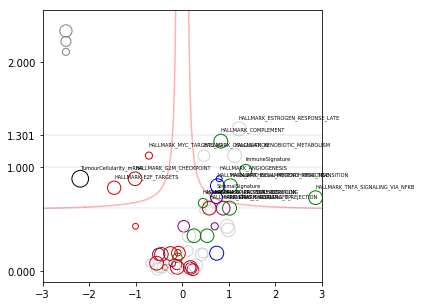

In [41]:
sig_sets = []
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for i in volcano_data.index:
    
    x = volcano_data.nes_dif[i]
    y = volcano_data.log10_q_comparison[i]
    c = volcano_data.colors[i]
    l = volcano_data.scores[i]
    s = volcano_data.msizes[i]
    plt.scatter(x, y, c='None', alpha=1, edgecolors=c, s=s, label=l)
    
    if y > -np.log10(0.25):
    
        plt.annotate(scores[i], xy=(x,y), xytext=(x, y+0.1), fontsize=5)
        sig_sets.append(scores[i])
    
plt.scatter(-2.5, 2.3, c='None', alpha=1, edgecolors='gray', s=150)
plt.scatter(-2.5, 2.2, c='None', alpha=1, edgecolors='gray', s=100)
plt.scatter(-2.5, 2.1, c='None', alpha=1, edgecolors='gray', s=50)
plt.plot([i[0] for i in curve_pos], [i[1] for i in curve_pos], 'r-', alpha=0.3)    
plt.plot([i[0] for i in curve_neg], [i[1] for i in curve_neg], 'r-', alpha=0.3)                
plt.axhline(y=-np.log10(0.25),alpha=0.1)
plt.axhline(y=-np.log10(0.1),alpha=0.1)
plt.axhline(y=-np.log10(0.05),alpha=0.1)
plt.xlim((-3,3))
plt.ylim((-0.1,2.5))
plt.yticks([-np.log10(1),-np.log10(0.1),-np.log10(0.05),-np.log10(0.01)])

plt.show()

In [42]:
fig.savefig('../../Figures/main/6/panels/6a_NACT_paired_matched_hallmarks_comparisons.pdf')

## Unmatched comparison

In [43]:
scores = []
p_comparisons = []
nes_dif = []
nes_treated_list = []
nes_untreated_list = []
nes_norm_treated_list = []
nes_norm_untreated_list = []
q_value_treated = []
q_value_untreated = []
colors = []
msizes = []
for score in data_nes.T:

    df_nes = pd.concat([sample_labels['Matched'],
                        sample_labels['NACT'],
                        data_nes.T[score]],
                        axis=1)

    df_nes = df_nes[df_nes['Matched'] == False]

    norm = test_normality_and_variance(df_nes, score)

    scores.append(score)
    p_comparisons.append(test_difference(df_nes, score, norm))
    nes_treated_list.append(df_nes[df_nes.NACT=='Treated'][score].median())
    nes_untreated_list.append(df_nes[df_nes.NACT=='Untreated'][score].median())
    nes_dif.append(nes_difference(df_nes, score)[0])
    nes_norm_treated_list.append(nes_difference(df_nes, score)[1])
    nes_norm_untreated_list.append(nes_difference(df_nes, score)[2])
    colors.append(color_sets.get(score,'k'))
    
    if score in msize_dt:
        msizes.append(msize_dt[score])
    else:
        raise ValueError()

qs = multipletests(pvals=p_comparisons,
                   alpha=0.05,
                   method='fdr_bh',
                   is_sorted=False)

/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-pack

/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-pack

In [44]:
ps_real = p_comparisons
qs_real = qs[1]
log10_ps_plot = abs(np.log10(p_comparisons))
log10_qs_plot = abs(np.log10(qs[1]))

### Volcano plot

In [45]:
volcano_data = pd.DataFrame({'scores': pd.Series(scores),
                             'qs':pd.Series(qs_real),
                             'ps':pd.Series(ps_real),
                             'log10_q_comparison': pd.Series(log10_qs_plot),
                             'log10_p_comparison': pd.Series(log10_ps_plot),
                             'nes_dif': pd.Series(nes_dif),
                             'nes_treated': pd.Series(nes_treated_list),
                             'nes_untreated': pd.Series(nes_untreated_list),
                             'nes_norm_treated': pd.Series(nes_norm_treated_list),
                             'nes_norm_untreated': pd.Series(nes_norm_untreated_list),
                             'colors': pd.Series(colors),
                             'msizes':pd.Series(msizes)})

In [46]:
volcano_data[volcano_data.scores == 'TumourCellularity_mRNA']

,scores,qs,ps,log10_q_comparison,log10_p_comparison,nes_dif,nes_treated,nes_untreated,nes_norm_treated,nes_norm_untreated,colors,msizes
52,TumourCellularity_mRNA,0.677069,0.485446,0.169367,0.313859,0.198384,0.713719,0.690764,0.540076,0.470691,k,278


### Hyperbolic curves

In [47]:
sample_size = len(df_nes)/2

In [48]:
t0 = 1.2
s0 = 0.1/t0

In [49]:
xs = range(-3 * 100, 3 *100)

## generate the x-axis for a hyperbolic curve defined as above
curve = [i/100 for i in xs if abs(i/100) > s0 * t0]

## generate the coordinates (x, y) for a hyperbolic curve defined as above
curve = [(i, hyperbolic(i, s0=s0, t0=t0)) for i in curve]

curve_pos = curve[:91]
curve_neg = curve[91:]

In [50]:
volcano_data.sort_values(by='msizes', inplace=True)

#### Volcano plot

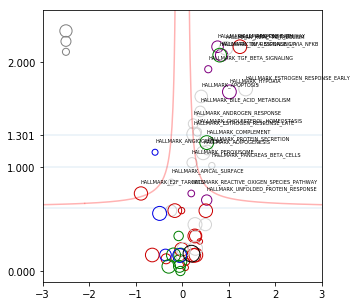

In [52]:
sig_sets = []
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for i in volcano_data.index:
    
    x = volcano_data.nes_dif[i]
    y = volcano_data.log10_q_comparison[i]
    c = volcano_data.colors[i]
    l = volcano_data.scores[i]
    s = volcano_data.msizes[i]
    plt.scatter(x, y, c='None', alpha=1, edgecolors=c, s=s, label=l)
    
    if y > -np.log10(0.25):
    
        plt.annotate(scores[i], xy=(x,y), xytext=(x, y+0.1), fontsize=5)
        sig_sets.append(scores[i])
    
plt.scatter(-2.5, 2.3, c='None', alpha=1, edgecolors='gray', s=150)
plt.scatter(-2.5, 2.2, c='None', alpha=1, edgecolors='gray', s=100)
plt.scatter(-2.5, 2.1, c='None', alpha=1, edgecolors='gray', s=50)
plt.plot([i[0] for i in curve_pos], [i[1] for i in curve_pos], 'r-', alpha=0.3)    
plt.plot([i[0] for i in curve_neg], [i[1] for i in curve_neg], 'r-', alpha=0.3)                
plt.axhline(y=-np.log10(0.25),alpha=0.1)
plt.axhline(y=-np.log10(0.1),alpha=0.1)
plt.axhline(y=-np.log10(0.05),alpha=0.1)
plt.xlim((-3,3))
plt.ylim((-0.1,2.5))
plt.yticks([-np.log10(1),-np.log10(0.1),-np.log10(0.05),-np.log10(0.01)])

plt.show()

In [53]:
fig.savefig('../../Figures/main/6/panels/6a_NACT_paired_unmatched_hallmarks_comparisons.pdf')

# End script

In [48]:
import seaborn as sns

In [49]:
# Compare post-NACT matched vs unmatched immune signature TumourCellularity_mRNA

In [50]:
data_nes.T.head()

Term,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_HYPOXIA,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_MITOTIC_SPINDLE,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_IL6_JAK_STAT3_SIGNALING,HALLMARK_DNA_REPAIR,HALLMARK_G2M_CHECKPOINT,HALLMARK_APOPTOSIS,...,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_PEROXISOME,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_SPERMATOGENESIS,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_PANCREAS_BETA_CELLS,StromalSignature,ImmuneSignature,TumourCellularity_mRNA
A01,0.092696,0.186010,0.255208,0.305218,0.218775,0.319309,0.063204,0.283149,0.366102,0.293164,...,0.017703,0.157014,0.101102,0.059223,0.168870,-0.111366,-0.146457,0.068301,0.074691,0.794327
A02,0.159109,0.196143,0.282680,0.317705,0.238017,0.390819,0.120196,0.355469,0.367244,0.323681,...,0.013351,0.210357,0.187103,0.088553,0.199723,-0.116319,-0.171530,0.070667,0.169467,0.766668
A03,0.221560,0.214819,0.285083,0.293826,0.212214,0.323519,0.219716,0.279329,0.272018,0.368760,...,0.068881,0.159303,0.240944,-0.013733,0.262265,-0.122007,-0.229520,0.269651,0.345730,0.591924
A04,0.210024,0.237168,0.260298,0.255306,0.256485,0.275202,0.167111,0.246652,0.212474,0.323310,...,0.069575,0.211824,0.206219,0.075459,0.241376,-0.096597,-0.139607,0.224186,0.317359,0.621334
A05,0.099785,0.192770,0.321267,0.278673,0.252541,0.274844,0.080244,0.286553,0.344719,0.301616,...,0.046353,0.200961,0.113492,0.074904,0.125993,-0.106269,-0.137008,0.023423,0.069114,0.816969


In [74]:
#score = "ImmuneSignature"
score = "TumourCellularity_mRNA"

In [75]:
im_nes_df = pd.concat(
    [sample_labels['Matched'],
    sample_labels['NACT'],
    data_nes.T[score]],
    axis=1
)

im_nes_df.head()

,Matched,NACT,TumourCellularity_mRNA
Well,,,
A01,True,Untreated,0.794327
A02,True,Treated,0.766668
A03,True,Untreated,0.591924
A04,True,Treated,0.621334
A05,True,Untreated,0.816969


In [76]:
untreated_df = im_nes_df[im_nes_df["NACT"] == "Untreated"]
treated_df = im_nes_df[im_nes_df["NACT"] == "Treated"]

In [77]:
bartlett(
    untreated_df[untreated_df["Matched"] == True][score],
    untreated_df[untreated_df["Matched"] == False][score]
)
# same variance

BartlettResult(statistic=1.0636895859970412, pvalue=0.3023751819154189)

In [78]:
levene(
    untreated_df[untreated_df["Matched"] == True][score],
    untreated_df[untreated_df["Matched"] == False][score]
)
# same variance

LeveneResult(statistic=0.5368938398490323, pvalue=0.4702777014377597)

In [79]:
shapiro(untreated_df[untreated_df["Matched"] == True][score])

(0.8408161401748657, 0.058974139392375946)

In [80]:
shapiro(untreated_df[untreated_df["Matched"] == False][score])

(0.9127862453460693, 0.0832914263010025)

In [81]:
mean = np.mean(untreated_df[untreated_df["Matched"]==True][score])
std = np.std(untreated_df[untreated_df["Matched"]==True][score])

kstest(list(untreated_df[untreated_df["Matched"]==True][score]),
       'norm', args=(mean,std))


KstestResult(statistic=0.24387978698439655, pvalue=0.5901700775401482)

In [82]:
mean = np.mean(untreated_df[untreated_df["Matched"]==False][score])
std = np.std(untreated_df[untreated_df["Matched"]==False][score])

kstest(list(untreated_df[untreated_df["Matched"]==False][score]),
       'norm', args=(mean,std))


KstestResult(statistic=0.11720971345690101, pvalue=0.9565382413024685)

In [83]:
ttest_ind(
    untreated_df[untreated_df["Matched"]==True][score],
    untreated_df[untreated_df["Matched"]==False][score],
    equal_var=True
)


Ttest_indResult(statistic=1.1819797214105436, pvalue=0.2479116008203142)

In [84]:
mannwhitneyu(
    untreated_df[untreated_df["Matched"] == True][score],
    untreated_df[untreated_df["Matched"] == False][score], alternative='two-sided'
)

MannwhitneyuResult(statistic=114.0, pvalue=0.16839692203854006)

In [85]:
score

'TumourCellularity_mRNA'

In [86]:
# treated

In [87]:
bartlett(
    treated_df[treated_df["Matched"] == True][score],
    treated_df[treated_df["Matched"] == False][score]
)
# same variance

BartlettResult(statistic=0.19061320081116814, pvalue=0.662406745157833)

In [88]:
levene(
    treated_df[treated_df["Matched"] == True][score],
    treated_df[treated_df["Matched"] == False][score]
)
# same variance

LeveneResult(statistic=0.6341060735084465, pvalue=0.43306435953738565)

In [89]:
shapiro(treated_df[treated_df["Matched"] == True][score])

(0.7960711717605591, 0.01841529831290245)

In [90]:
shapiro(treated_df[treated_df["Matched"] == False][score])

(0.9190979599952698, 0.10890509188175201)

In [91]:
mean = np.mean(treated_df[treated_df["Matched"]==True][score])
std = np.std(treated_df[treated_df["Matched"]==True][score])

kstest(list(treated_df[treated_df["Matched"]==True][score]),
       'norm', args=(mean,std))

KstestResult(statistic=0.31746318823051045, pvalue=0.2635841803177216)

In [92]:
mean = np.mean(treated_df[treated_df["Matched"]==False][score])
std = np.std(treated_df[treated_df["Matched"]==False][score])

kstest(list(treated_df[treated_df["Matched"]==False][score]),
       'norm', args=(mean,std))

KstestResult(statistic=0.18384400644042248, pvalue=0.49218133352564)

In [93]:
ttest_ind(
    treated_df[treated_df["Matched"] == True][score],
    treated_df[treated_df["Matched"] == False][score],
    equal_var=True
)

Ttest_indResult(statistic=-1.5265797639975707, pvalue=0.13893996517390572)

In [94]:
mannwhitneyu(
    treated_df[treated_df["Matched"] == True][score],
    treated_df[treated_df["Matched"] == False][score]
)

MannwhitneyuResult(statistic=55.0, pvalue=0.07000458192059181)

In [74]:
def boxplot(data_toplot, score, ylim=None):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(3,3)

    sns.violinplot(x="Matched",
                   y=score,
                   data=data_toplot,
                   inner=None,
                   hue="Matched",
                   split=False,
                   scale="count",
                   scale_hue=False,
                   zorder=0)

    sns.boxplot(x='Matched',
                y=score,
                data=data_toplot,
                notch=True,
                fliersize=0,
                width=0.5,
                hue="Matched",
                zorder=1,
                whis=0)

    
    
    if ylim != None:
        plt.ylim(ylim)
        
    #sns.despine(trim=True,offset=10)
    ax.get_legend().remove()
    
    return fig

In [75]:
score = "ImmuneSignature"

In [76]:
im_nes_df = pd.concat(
    [sample_labels['Matched'],
    sample_labels['NACT'],
    data_nes.T[score]],
    axis=1
)

im_nes_df.head()

,Matched,NACT,ImmuneSignature
Well,,,
A01,True,Untreated,0.074691
A02,True,Treated,0.169467
A03,True,Untreated,0.345730
A04,True,Treated,0.317359
A05,True,Untreated,0.069114


In [77]:
df = im_nes_df[im_nes_df["NACT"] == "Treated"]

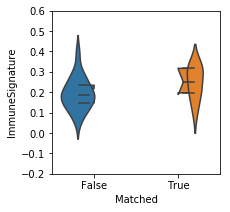

In [78]:
fig = boxplot(df, score, ylim=[-0.2,0.6])

In [ ]:
fig.savefig("../2.Plots/x7_post-NACT_"+score+".pdf")

In [ ]:
len(df[df.Matched == False])